In [1]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from bson.objectid import ObjectId
import time
import datetime

In [2]:
!pip install colorama

In [3]:
with open('intents.json') as file:
    data = json.load(file)
    
train_patterns = [] # patterns
train_intents = [] # tags
labels = [] #tags
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        train_patterns.append(pattern)
        train_intents.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [4]:
print("train_patterns :", train_patterns[100])
print("train_intents :", train_intents[100])
print("num_classes :", num_classes)

train_patterns : I am hungry
train_intents : menu
num_classes : 23


### Then we use `LabelEncoder()` function provided by scikit-learn to convert the target labels into a model understandable form.

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(train_intents)
train_intents = label_encoder.transform(train_intents)

## Vectorization

- We vectorize our text data corpus by using the “Tokenizer” class and it allows us to limit our vocabulary size up to some defined number. 

- When we use this class for the text pre-processing task, by default all punctuations will be removed, turning the texts into space-separated sequences of words, and these sequences are then split into lists of tokens. 

- They will then be indexed or vectorized. We can also add “oov_token” which is a value for “out of token” to deal with out of vocabulary words(tokens) at inference time.

- The “pad_sequences” method is used to make all the training text sequences into the same size.

In [6]:
vocab_size = 11250
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=None)
tokenizer.fit_on_texts(train_patterns)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_patterns)

padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [7]:
print("train_patterns :", train_patterns[99])
print("sequences: ", sequences[99])

train_patterns : Im damn hungry
sequences:  [204, 205, 128]


## 1) Here, we have to deal with multiple inputs or multiple outputs. Hence, we'll use `Keras` `Sequential()` model.

read more : [Kears Sequential model details](https://keras.io/guides/sequential_model/)

## 2) Loss Function: `sparse_categorical_crossentropy` : We are using this crossentropy loss function when there are two or more label classes.
read more about [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [8]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            180000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 23)                391       
Total params: 180,935
Trainable params: 180,935
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs = 500
history = model.fit(padded_sequences, np.array(train_intents), epochs=epochs)

Epoch 1/500
12/12 [==============================] - 0s 2ms/step - loss: 3.1304 - accuracy: 0.1301
Epoch 2/500
12/12 [==============================] - 0s 2ms/step - loss: 3.1190 - accuracy: 0.1301
Epoch 3/500
12/12 [==============================] - 0s 1ms/step - loss: 3.1077 - accuracy: 0.1301
Epoch 4/500
12/12 [==============================] - 0s 2ms/step - loss: 3.0931 - accuracy: 0.1301
Epoch 5/500
12/12 [==============================] - 0s 2ms/step - loss: 3.0745 - accuracy: 0.1301
Epoch 6/500
12/12 [==============================] - 0s 1ms/step - loss: 3.0521 - accuracy: 0.1301
Epoch 7/500
12/12 [==============================] - 0s 2ms/step - loss: 3.0242 - accuracy: 0.1301
Epoch 8/500
12/12 [==============================] - 0s 1ms/step - loss: 2.9935 - accuracy: 0.1301
Epoch 9/500
12/12 [==============================] - 0s 1ms/step - loss: 2.9590 - accuracy: 0.1301
Epoch 10/500
12/12 [==============================] - 0s 1ms/step - loss: 2.9296 - accuracy: 0.1301
Epoch 11/

In [10]:
history_dict = history.history

Text(0.5, 0, 'Epochs')

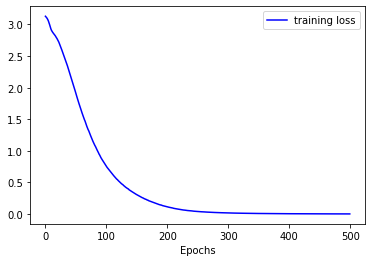

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


loss_values = history_dict['loss']
#val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
#plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

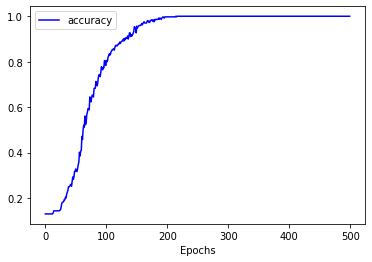

In [12]:
accuracy_values = history_dict['accuracy']
#val_accuracy_values=history_dict['val_accuracy']
#plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")

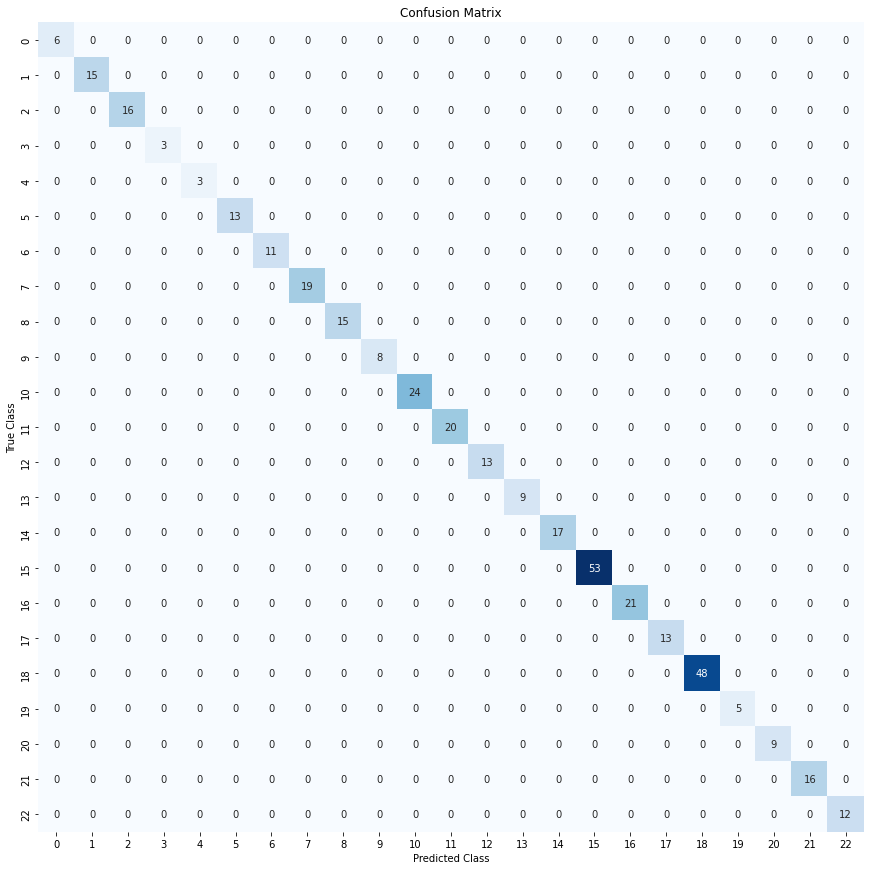

In [13]:
y_pred = model.predict(padded_sequences)
y_result=[]
for i in y_pred:
    max_value = max(i)
    #print(max_value)
    y_result.append(np.where(i == max_value)[0][0])





from sklearn.metrics import confusion_matrix
#CM matrix for training data
plt.figure(figsize=(12,12))

matrix_nn = confusion_matrix(y_result, np.array(train_intents))

sns.heatmap(matrix_nn, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

## Save the models

We are saving 3 different things separately
- Classification model
- fitted Tokenizer object
- fitted label encoder object

In [14]:
# saving model
model.save("chat_model")

import pickle

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

# saving label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(label_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: chat_model\assets


In [15]:
!pip install pymongo

In [16]:
!pip show pymongo
!pip show bson


Name: pymongo
Version: 4.1.1
Summary: Python driver for MongoDB <http://www.mongodb.org>
Home-page: http://github.com/mongodb/mongo-python-driver
Author: The MongoDB Python Team
Author-email: 
License: Apache License, Version 2.0
Location: c:\users\valav\anaconda3\envs\gpu2\lib\site-packages
Requires: 
Required-by: 


In [17]:
import json
import random
import datetime
import pymongo
import uuid

In [18]:
import pymongo
import urllib.parse

# Make sure Settings->Network Access has correct settings

username = urllib.parse.quote_plus("valavalasanjeevi")  # Replace with your MongoDB username
password = urllib.parse.quote_plus("sanju")  # Replace with your MongoDB password
cluster_address = "cluster0.ukzqrkk.mongodb.net"  # Replace with your cluster address
database_name = "delishapp"  # Replace with your database name

URI = f"mongodb+srv://{username}:{password}@{cluster_address}/{database_name}?retryWrites=true&w=majority"
client = pymongo.MongoClient(URI, connect=False)

db = client[database_name]
menu_collection = db["menu"]
feedback_collection = db["feedback"]
order_collection = db["Orders"]
bookings_collection = db["bookings"]

# Check the connection
try:
    client.admin.command('ping')
    print("Connected to MongoDB!")
except Exception as e:
    print(f"Connection failed: {e}")


Connected to MongoDB!


In [19]:
seat_count = 50
import urllib.parse
# Make sure Settings->Network Access has correct settings


username = urllib.parse.quote_plus("valavalasanjeevi")  # Replace with your MongoDB username
password = urllib.parse.quote_plus("sanju")  # Replace with your MongoDB password
cluster_address = "cluster0.ukzqrkk.mongodb.net"  # Replace with your cluster address
database_name = "delishapp"  # Replace with your database name

URI = f"mongodb+srv://{username}:{password}@{cluster_address}/{database_name}?retryWrites=true&w=majority"
client = pymongo.MongoClient(URI, connect=False)

db = client[database_name]
menu_collection = db["menu"]
feedback_collection = db["feedback"]
order_collection = db["Orders"]
bookings_collection = db["bookings"]


In [20]:
query = {"mainmenu": "Y"}

veg_data = menu_collection.find(query)
x=[]
for i in veg_data:
    if (i.get("breakfast")=="N") == True:
        x.append(i.get("item"))
x

[]

In [21]:
# Order
def record_order(message):
    print("Saving customers order")
    print(message)
    items_ = message.split("||")


    arr_dict={}
    for j,i in enumerate(items_[1:-1]):
 
        str1_ = i.split(",")
        dict_name='item {}'.format(j)
        arr_dict[dict_name]={}
    
        arr_dict[dict_name]['item'] = str1_[0].split(":")[1]
        arr_dict[dict_name]['price'] = str1_[1].split(":")[1]
        arr_dict[dict_name]['quantity'] = str1_[2].split(":")[1]
        #print(arr_dict[dict_name])
    

    
    arr_dict["Total Price"]={}
    arr_dict["order_details"]={}
         
    orderplaced_id = str(uuid.uuid4())
    arr_dict["Total Price"]["total bill"] = items_[0].split(":")[1]
    arr_dict["order_details"]["OrderID"] = orderplaced_id
    
    # Adding the ordering time:
    now_ = datetime.datetime.now()
    booking_time_ = now_.strftime("%Y-%m-%d %H:%M:%S")
    arr_dict["order_details"]["OrderTime"] = booking_time_
    arr_dict["order_details"]["OrderStatus"]="placed"
   
    
    
    
    # Make the array of nested dictionary
    item_dict=[]
    item_dict.append(arr_dict)
    
    nested_dictionary =item_dict
    order_collection.insert_many(nested_dictionary)
    return orderplaced_id
    # get the order id
    
    
    
# Cancel Order
def cancel_order(order_id):
    print(order_id)
    result={}
    status_=""
    query = {"order_details.OrderID": order_id}
    doc_ = order_collection.find(query)
    
    for x in doc_:
        result = x
        
    print(result)
    
    
   
        
    if result:
        status_=result["order_details"]["OrderStatus"]
        od_id = result["_id"]
        print(od_id)
        print(status_)
        if status_ == 'placed':
            


            order_itemX=['Total Price','_id','order_details', 'OrderStatus']
            cancelStr = "Cancelling your order with : "
            for i in result:
                if i not in order_itemX:
                    cancelStr+= "("+result[i]['quantity'] + "-" + result[i]['item'] + ") "
            
   
            cancelStr+="💰 ₹" + result['Total Price']['total bill'] + " will be refunded to your account."
            
           
            order_collection.replace_one({"_id" :od_id },  {"order_details":{"OrderID":order_id,"OrderStatus":"canceled"}})
            update_data = order_collection.find_one({"_id":od_id})
            print(update_data["order_details"]["OrderStatus"])
            
            return cancelStr
        
        else:
            return "🚫 This order has been canceled already."
    
    else:
        return "Please enter correct Order ID and 📌before entering order ID send the 'cancel Order' message again." 


# Order Status


def order_status(order_id):
    making = "00:05:00"
    made = "00:20:00"
    delivery = "00:35:00"
    
    print(order_id)
    result={}
    order_status=""
    status_=""
    query = {"order_details.OrderID": order_id}
    doc_ = order_collection.find(query)
    
    for x in doc_:
        result = x
        
    print(result)

    if result:
        status_=result["order_details"]["OrderStatus"]
        od_id = result["_id"]
        print(od_id)
        print(status_)
        if status_ == 'placed':
            order_t = datetime.datetime.strptime(result["order_details"]["OrderTime"].split(" ")[1], "%H:%M:%S")
            seconds_ = (datetime.datetime.now() - order_t).seconds
            time_gap = time.strftime("%H:%M:%S", time.gmtime(seconds_))
            
            #> 20 minutes
            if (datetime.datetime.strptime(time_gap, "%H:%M:%S") > datetime.datetime.strptime(made, "%H:%M:%S")) and (datetime.datetime.strptime(time_gap, "%H:%M:%S") < datetime.datetime.strptime(delivery, "%H:%M:%S")):
                order_status = "Your order is on the way. 🚀"

            #between 5-20 minutes
            elif (datetime.datetime.strptime(time_gap, "%H:%M:%S") <= datetime.datetime.strptime(made, "%H:%M:%S")) and (datetime.datetime.strptime(time_gap, "%H:%M:%S") > datetime.datetime.strptime(making, "%H:%M:%S")):
                order_status = "Your food is being prepared. 🍜"
                
            #<5 minutes
            elif datetime.datetime.strptime(time_gap, "%H:%M:%S") < datetime.datetime.strptime(making, "%H:%M:%S"):
                order_status = "You order has been placed and chef is about to start cooking. 👩‍🍳"

            #>35 minutes
            elif datetime.datetime.strptime(time_gap, "%H:%M:%S") > datetime.datetime.strptime(delivery, "%H:%M:%S"):
                order_status = "We regret for delay in your food delivery, please contact our delivery agent or ask for refund.We assure you of speedy and safe delivery nect time. 🙏"
    
            else:
                order_status = "Food is already delivered.🍱"
            
            
            

            return order_status
        
        else:
            return "🚫 This order has been canceled already."
    
    else:
        return "Please enter correct Order ID and 📌before entering order ID send the 'Order Status' message again." 


 
    
    
# Book a table:
seat_count = 50
def book_table():
    global seat_count
    seat_count = seat_count - 1
    booking_id = str(uuid.uuid4())
    now = datetime.datetime.now()
    booking_time = now.strftime("%Y-%m-%d %H:%M:%S")
    booking_doc = {"booking_id": booking_id, "booking_time": booking_time}
    bookings_collection.insert_one(booking_doc)
    return booking_id


def get_specific_response(tag):
    for intent in data['intents']:
        if intent['tag'] == tag:
            responses = intent['responses']
    response = random.choice(responses)
    return response


def show_menu():
    all_items = menu_collection.distinct('item')
    response = ', '.join(all_items)
    return response

def record_feedback(message, type):
    print("Recording your feedback")
    feedback_doc = {"feedback_string": message, "type": type}
    feedback_collection.insert_one(feedback_doc)
    
def recipe_enquiry(inp):
    response=""
    for i in menu_collection.distinct('item'):
        if i.lower() in inp.lower():
            #print(i)
            #if inp.lower()== i.lower():
        
            query_about= {"item":i}
            about = menu_collection.find(query_about)
            for j in about:
                response = j.get("details")
        
            
    if response =="":
        response = "I don't know much about this recipe! But, you can contact our restaurant for more details."
    return response


def suggest():
    day = datetime.datetime.now()
    day = day.strftime("%A")
    if day == "Monday":
        response = "I would recommend: Paneer Roll and Chicken Biryani"
    elif day == "Tuesday":
        response = "I would recommend: Cheese Grilled Sandwich and Chicken tripple rice"

    elif day == "Wednesday":
        response = "I would recommend: Egg Roll and Latte "

    elif day == "Thursday":
        response = "I would recommend: Mixed Fruit Juice and Chicken cheese sandwich"

    elif day == "Friday":
        response = "I would recommend: White Sauce Pasta and Cheese cake"

    elif day == "Saturday":
        response = "I would recommend: Chicken Roll and cold coffee"

    elif day == "Sunday":
        response = "I would recommend: Schezwan Rice and Manchurian"
    return response


def veg_menu():
    res=[]    
    query = {"veg": "Y"}
    b_query = {"Breads": "Y"}
    d_query = {"Desert": "Y"}
    i_query = {"icecreams_bev":"Y"}
    breads=[]
    deserts =[]
    ice_bev=[]


    b_doc = menu_collection.find(b_query)
    for x in b_doc:
        breads.append(x.get("item"))
    
    d_doc = menu_collection.find(d_query)
    for x in d_doc:
        deserts.append(x.get("item"))
    
    i_doc = menu_collection.find(i_query)
    for x in i_doc:
        ice_bev.append(x.get("item")) 
        
        
    veg_doc = menu_collection.find(query)
    for x in veg_doc:
        if x.get("item") not in exclude_items:
            res.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        
        
    return res



def nonveg_menu():
    re=[]
    query = {"nonveg": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        re.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        #response = response[:-2] # to remove the last ;
        #print(response,"\n")
    return re




def breakfast_menu():
    br=[]
    query = {"breakfast": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        br.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        #response = response[:-2] # to remove the last ;
        #print(response,"\n")
    return br

def bevrages_menu():
    bev=[]
    query = {"icecreams_bev": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        bev.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        #response = response[:-2] # to remove the last ;
        #print(response,"\n")
    return bev

def desert_menu():
    de=[]
    query = {"Desert": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        de.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        #response = response[:-2] # to remove the last ;
        #print(response,"\n")
    return de

def snacks_menu():
    sn=[]
    query = {"snacks": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        sn.append(str(x.get("item")) + " for Rs. " + str(x.get("cost")) + "\n")
        #response = response[:-2] # to remove the last ;
        #print(response,"\n")
    return sn


def main_menu():
    menu=[]
    query = {"mainmenu": "Y"}
    doc = menu_collection.find(query)
    for x in doc:
        menu.append(str(x.get("item")) +"\n")
   
    return menu

def offers():
    
    response = "Sorry there are no offers available now."
    return response

In [22]:
def generate_response(tag, user_input):
    global seat_count
    #tag = get_intent(message)
    response = ""
    if tag != "":
        if tag == "book_table":

            if seat_count > 0:
                booking_id = book_table()
                response = "Your table has been booked successfully :" + str(
                    booking_id)
            else:
                response = "Sorry we are sold out now!"


        elif tag == "available_tables":
            response = "Right now, there are " + str(seat_count) + " table(s) available."

        elif tag == "veg_enquiry":
            response ="Hey, You can discover our amazing vegetarian options in the Menu section on your left."

        elif tag == "nonveg_enquiry":
            response = "Hey, You can discover Non-vegetarian food options in the Menu section on your left."
            
        elif tag == "vegan_enquiry":
            response = "Sorry, We don't serve Vegan Food"

        elif tag == "offers":
            response =offers()

        elif tag == "suggest":
            
            response =suggest()
            response+="\n"+"Or else you can check our populars in the Menu section!!"

        elif tag == "recipe_enquiry":
            response =recipe_enquiry(user_input)

        elif tag == "menu":
            response="Checkout our lip-smacking food options on your left. Just add whichever food item you like." + "\n" + "worried about recipes and ingredients? ask me!!. I've got you covered 😎"
            
        elif tag == "Icecreams_bevrages":
            response = "Checkout Desserts option for the refreshing bevrages!! 🍨"
            
        elif tag == "Quick_Bites":
            #response1 = snacks_menu()
            #response2= breakfast_menu()
            #response3 = bevrages_menu()
            #response = response1 + response2 + response3
            response = "Hey, You can explore breakfast, Snacks and Desserts options on your left for some quick refreshments!!"
            
        elif tag == "positive_feedback":
            record_feedback(user_input, "positive")
            response = "Huzzah!!😍 Thank you so much for your valuable feedback. We look forward to serving you again!"

        elif "negative_feedback" == tag:
            record_feedback(user_input, "negative")
            response = "Thank you so much for your valuable feedback. We deeply regret the inconvenience. We have " \
                       "forwarded your concerns to the authority and hope to satisfy you better the next time! 🙏"
        # for other intents with pre-defined responses that can be pulled from dataset
        else:
            response = get_specific_response(tag)
    else:
        response = "Sorry! I didn't get it, please try to be more precise."
    return response


### Load the model

In [23]:
def response_gen(message):
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([message]),truncating='post', maxlen=max_len))
    
    ## Find the intent
    tag = lbl_encoder.inverse_transform([np.argmax(result)])
    print(tag)

    for i in data['intents']:
        if i['tag'] == tag:
            output = generate_response(tag, message)
            
    return output
  
    

In [24]:
from flask import Flask, render_template, request, jsonify
import json 
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import os

ORDER_ID=False

TEMPLATE_DIR = os.path.abspath('./templates')
STATIC_DIR = os.path.abspath('./static')

app = Flask(__name__) #


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/get')
def get_bot_response():
    
    message = request.args.get('msg')
    #print(message)
    response = ""
    if message:
        if message.startswith("TotalPrice:"):
            print(message)
            o_id = record_order(message)
            id_res = "Your Order ID is : " + o_id + " Kindly remember this ID for the future reference."
            return id_res
        #Order Cancel
        elif message.endswith("-ORDERID"):
            # if intent is Cancel
            print(message)
            
            cancelOrderStr = cancel_order(message.split("-ORDERID")[0])
            
            return cancelOrderStr
        
        elif message.endswith("-STATUSID"):
            # if intent is Cancel
            print(message)
            
            statusOrderStr = order_status(message.split("-STATUSID")[0])
            
            return statusOrderStr
            
            
            
        else:
            response = response_gen(message)
            #print(response)
            
                
        
        return str(response)
    
    else:
        return "Missing Data!"
    


if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /style.css HTTP/1.1" 404 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item1.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item2.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /script.js HTTP/1.1" 404 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item5.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item4.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item6.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item7.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item8.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 19:13:37] "GET /static/images/item9.jpg HTTP/1.1" 2

['greeting']


127.0.0.1 - - [09/Jul/2024 19:13:55] "GET /get?msg=book+a+table HTTP/1.1" 200 -


['book_table']


Mongodb reference: https://kb.objectrocket.com/category/mongo-db